# AutoKeras API Notebook (Tool Demo)

This notebook demonstrates **AutoKeras** as a tool for image classification:

- What AutoKeras is (high-level)
- The main API object: `ak.ImageClassifier`
- Minimal workflow: `fit() → evaluate() → export_model() → save()`

This notebook is **tool-only** and uses a small built-in dataset (CIFAR-10), so it is not tied to any project-specific dataset or pipeline..ipynb`.


In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

Imports + version check

In [2]:
import tensorflow as tf
import autokeras as ak

print("TensorFlow:", tf.__version__)
print("AutoKeras:", ak.__version__)
print("Available GPUs:", tf.config.list_physical_devices("GPU"))

TensorFlow: 2.20.0
AutoKeras: 3.0.0
Available GPUs: []


2025-12-16 02:15:20.211544: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Note: `Available GPUs: []` is expected in this Docker CPU environment.
AutoKeras still works on CPU; this notebook keeps `max_trials` and `epochs` small so it runs quickly.

Load a tiny built-in dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Keep it tiny so it runs fast anywhere
x_train_small, y_train_small = x_train[:500], y_train[:500]
x_val_small, y_val_small = x_train[500:600], y_train[500:600]
x_test_small, y_test_small = x_test[:200], y_test[:200]

x_train_small.shape, y_train_small.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 106s 1us/step


((500, 32, 32, 3), (500, 1))

Visualizing a few samples

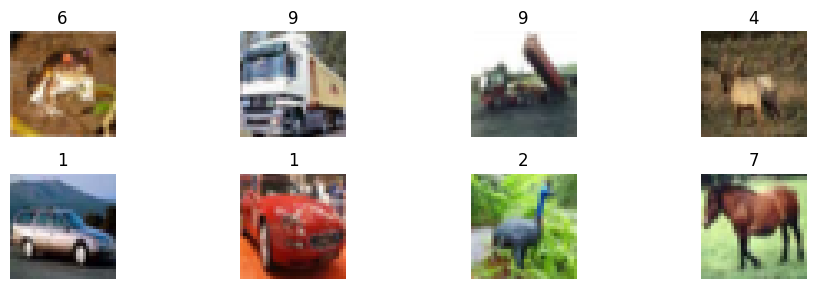

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_train_small[i])
    plt.axis("off")
    plt.title(int(y_train_small[i][0]))
plt.tight_layout()
plt.show()

## AutoKeras ImageClassifier

`ak.ImageClassifier` performs **neural architecture search (NAS)** automatically:
- It tries multiple candidate CNN architectures (`max_trials`)
- Trains each candidate for a few epochs
- Selects the best one based on validation performanceeasonable.


Creating classifier

In [5]:
clf = ak.ImageClassifier(
    max_trials=2,        # small for demo
    overwrite=True
)
print(clf)

In [6]:
history = clf.fit(
    x_train_small, y_train_small,
    validation_data=(x_val_small, y_val_small),
    epochs=2
)

Trial 2 Complete [00h 04m 54s]
val_loss: 2.262136936187744

Best val_loss So Far: 1.8838276863098145
Total elapsed time: 00h 04m 57s
Epoch 1/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1820 - loss: 2.2339 - val_accuracy: 0.2700 - val_loss: 2.0118
Epoch 2/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3640 - loss: 1.8105 - val_accuracy: 0.2900 - val_loss: 1.9706


I keep `max_trials` and `epochs` very small here so the API demo runs quickly on CPU.
The goal is to demonstrate the AutoKeras workflow, not maximize accuracy.

Evaluate

In [7]:
test_loss, test_acc = clf.evaluate(x_test_small, y_test_small, verbose=0)
print("Demo test accuracy:", test_acc)

/usr/local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Demo test accuracy: 0.25


Export best model (important AutoKeras feature)

In [8]:
best_model = clf.export_model()
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       125,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,849 (565.82 KB)

 Trainable params: 144,842 (565.79 KB)

 Non-trainable params: 7 (32.00 B)

In [9]:
best_model.save("autokeras_image_classifier_demo.keras")
print("Saved:", "autokeras_image_classifier_demo.keras")

Saved: autokeras_image_classifier_demo.keras


### Summary (Tool Takeaways)
- Created an `ak.ImageClassifier`
- Ran a small NAS search with `max_trials`
- Trained + evaluated on a tiny dataset
- Exported and saved the best Keras model